# Atmospheric River Events

In this notebook, we want to explore [Atmospheric River](https://en.wikipedia.org/wiki/Atmospheric_river) events in the REMO model data. We show how to integrate a 3D REMO field along the vertical axis using the pressure coordinate. We will sum the specific humidity $Q_D$ along the vertical axis weighted by the pressure difference to show atmospheric river events in the model data.

The integral looks like this: $ Q_{vi} = \int_{bottom}^{top} Q_d \,dp$

Let's fetch some REMO example output.

## Workflow

In [1]:
import pyremo as pr

tfile = pr.tutorial.load_dataset("remo_output_3d")

We define the formula for the computation of pressure levels here using the vertical hybrid sigma coefficients.

In [2]:
def pressure(ak, bk, ps):
    """Returns pressure levels

    Computes pressure levels from hybrid sigma coeffiecients
    using the surface pressure ps.

    """
    return ak + bk * ps

The hybrid sigma coefficients can be defined at level interfaces or mid levels depending on which locations we need. For this integration, we'll use the pressure differences between level interfaces while the specific humidity is defined on the mid levels. Consequently, we'll need to use `hyai` and `hybi` to compute the pressure field define on the level interfaces.

In [3]:
aki = tfile.hyai  # i: defined at level interfaces
bki = tfile.hybi
akm = tfile.hybm  # m: defined at mid levels
bkm = tfile.hybm

In [4]:
pi = pressure(aki, bki, tfile.PS)  # pressure at level interfaces
pm = pressure(akm, bkm, tfile.PS)  # pressure at mid levels

Let's check, that the bottom level of `pi` should be equal to the surface pressure.

In [5]:
(pi[27] == tfile.PS).all()

<xarray.DataArray ()>
array(True)

That should be `True`. Now, we'll compute the pressure differential along vertical axis.

In [6]:
dpi = pi.diff(dim="nhyi")
# do some xarray magic to make the pressure difference have the right level coordinate like
# the QD variable that we want to integrate.
dpi = dpi.rename({"nhyi": "lev"})
dpi["lev"] = tfile.lev

Now, let's do the math. We'll compute the integrant.

In [7]:
dQVI = tfile.QD * dpi

Now we can easily integrate along the vertical axis.

In [8]:
QVI = dQVI.sum(dim="lev")

Add consistent meta data

In [9]:
QVI.name = "QVI"
QVI.attrs = tfile.QD.attrs
ds = QVI.assign_attrs(
    units="kg/m/s",
    standard_name="integrated_specific_humidity",
    long_name="Integrated specific humidity",
).to_dataset()
ds["rotated_pole"] = tfile.rotated_pole
ds

<xarray.Dataset>
Dimensions:       (rlat: 121, rlon: 129, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 2006-01-01
  * rlon          (rlon) float64 -31.73 -31.29 -30.85 ... 23.71 24.15 24.59
  * rlat          (rlat) float64 -26.73 -26.29 -25.85 ... 25.19 25.63 26.07
Data variables:
    QVI           (time, rlat, rlon) float64 29.37 29.85 29.65 ... 6.588 6.583
    rotated_pole  int32 1

### Plot results of one timestep

In [10]:
pole = (
    ds.rotated_pole.grid_north_pole_longitude,
    ds.rotated_pole.grid_north_pole_latitude,
)
pole

(-162.0, 39.25)

In [11]:
def plot_contourf(da, pole, vmin=None, vmax=None, levels=20):
    %matplotlib inline
    import cartopy.crs as ccrs
    import cartopy.feature as cf

    # use ncar colormaps from https://github.com/hhuangwx/cmaps
    # conda install -c conda-forge cmaps
    import cmaps
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.RotatedPole(*pole))
    ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        xlocs=range(-180, 180, 10),
        ylocs=range(-90, 90, 5),
    )
    da.plot.contourf(
        ax=ax,
        cmap=cmaps.WhiteBlueGreenYellowRed,
        levels=levels,
        transform=ccrs.RotatedPole(*pole),
        vmin=vmin,
        vmax=vmax,
    )
    ax.coastlines(resolution="50m", color="black", linewidth=1)

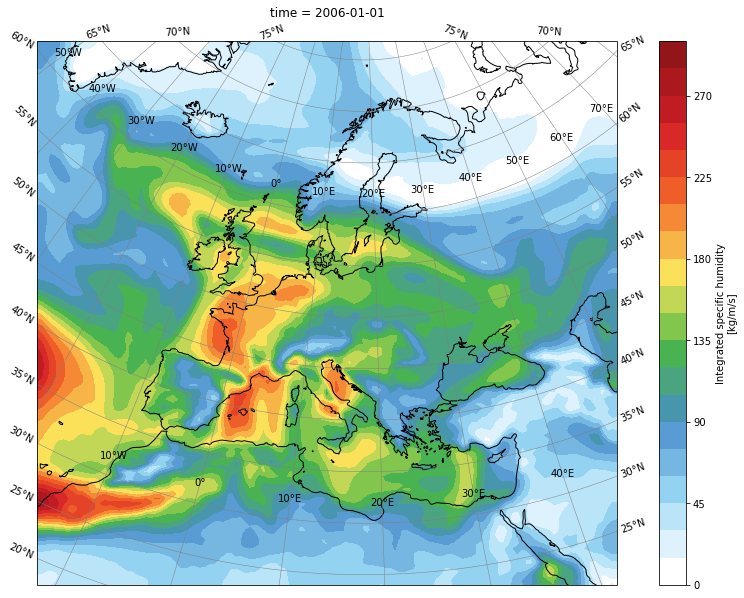

In [12]:
plot_contourf(ds.QVI.isel(time=0), pole)

### Summary: Structure our prototype code into functions

In [13]:
def pressure(ak, bk, ps):
    """Returns pressure levels

    Computes pressure levels from hybrid sigma coeffiecients
    using the surface pressure ps.

    """
    return ak + bk * ps


def integrate_vertical_by_pressure(da, p):
    """Integrates a variable along the vertical.

    Integrates the variable in the vertical along the
    pressure coordinate.

    """
    dp = p.diff(dim="nhyi")
    dp = dp.rename({"nhyi": "lev"})
    dp["lev"] = da.lev
    dda = da * dp
    return dda.sum(dim="lev")


def compute_qvi(ds):
    """Integrates"""
    pi = pressure(ds.hyai, ds.hybi, ds.PS)  # pressure at level interfaces
    qvi = integrate_vertical_by_pressure(ds.QD, pi)
    # make meta data consistent...
    qvi.name = "QVI"
    qvi.attrs = ds.QD.attrs
    result = qvi.assign_attrs(
        units="kg/m/s",
        standard_name="integrated_specific_humidity",
        long_name="Integrated specific humidity",
    ).to_dataset()
    result["rotated_pole"] = ds.rotated_pole
    return result

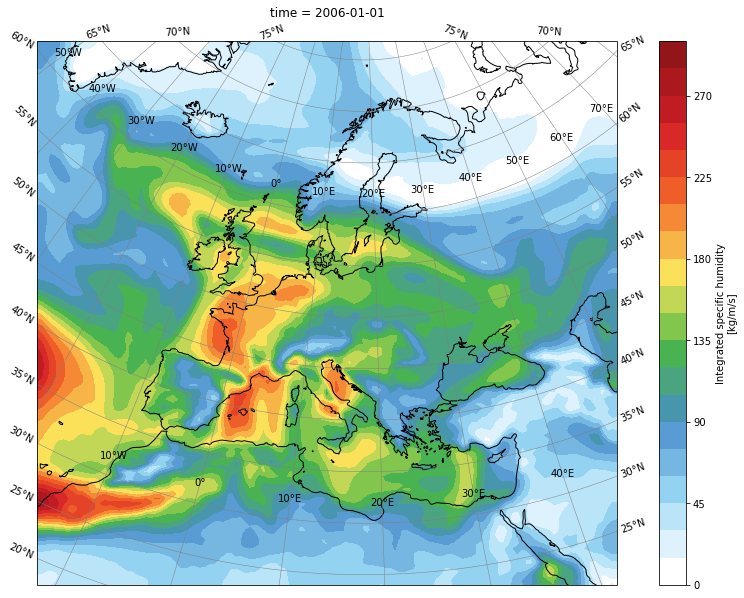

In [14]:
qvi = compute_qvi(tfile)
plot_contourf(qvi.QVI.isel(time=0), pole)

## Use Timeseries from REMO output

**NOTE**: Only possible with access to Mistral!

We will use 3D data from one month of REMO output here.

In [16]:
import os
import tarfile

tar = tarfile.open("/work/ch0636/g300046/remo_results_056524/2005/e056524t200509.tar")
scratch = os.path.join(os.getenv("SCRATCH"), "tar-tmp")
# tar.extractall(scratch) comment out if already extracted...

In [ ]:
# optional, use dask client for parallel processing
from dask.distributed import Client

client = Client()
client

Here, we need some code to convert classical REMO IEG output into NetCDF format. We use a simple [dask delayed](https://examples.dask.org/applications/embarrassingly-parallel.html) approach to convert the files in parallel. Note, that in the future, REMO will produce native NetCDF output which we can process without any further postprocessing.

In [17]:
import subprocess

# from cdo import Cdo
# python cdo bindings don't work with dask because of
# incorrect signal handling...
from glob import glob

filenames = glob(os.path.join(scratch, "*"))
# cdo = Cdo(tempdir=os.path.join(scratch, 'nc'))


def cdo_call(options="", op="", input="", output=None):
    call = f"cdo {options} {op} {input} {output}"
    subprocess.Popen(call, shell=True, stdout=subprocess.PIPE).stdout.read()
    return output
    # return subprocess.run("cdo {} {} {} {}".format(options, op, input, output), shell=True)


def convert_with_cdo(f):
    """Convert a single file into NetCDF format."""
    file = os.path.basename(f)
    path = os.path.dirname(f)
    # cdo = Cdo()
    # return cdo.copy(options='-f nc', input=f, output=os.path.join(path,'nc',file+'.nc'))
    return cdo_call(
        options="-f nc",
        op="copy",
        input=f,
        output=os.path.join(path, "nc", file + ".nc"),
    )


def convert_files(files, with_dask=False):
    """Convert many files into NetCDF format."""
    results = []
    if with_dask:
        from dask import delayed
    else:

        def delayed(x):
            return x

    for f in files:
        if os.path.isfile(f):
            nc = delayed(convert_with_cdo)(f)
            results.append(nc)
    return results

In [18]:
import dask
from dask.distributed import progress

output = convert_files(filenames, with_dask=True)
nc_files = dask.persist(output)
progress(nc_files)

VBox()

In [19]:
nc_files_ = dask.compute(nc_files)[0][0]

In [23]:
nc_files_ = glob(os.path.join(scratch, "nc", "*.nc"))
nc_files_.sort()

### Access NetCDF files

We use an optimized function here for opening large datasets that consist of many files:

In [24]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={"time": 1},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """
    import xarray as xr

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [25]:
nc_files_.sort()
%time remo_data = open_mfdataset(nc_files_)

CPU times: user 13.8 s, sys: 556 ms, total: 14.3 s
Wall time: 19.7 s


The old converted NetCDF files miss some meta data and a consistent calendar which we correct here.

In [26]:
from pyremo import remo_ds as rds

remo_data = rds.update_meta_info(remo_data)

In [27]:
remo_data = rds.parse_dates(remo_data, use_cftime=True)

### Process the timeseries

Now, we can process the xarray dataset timeseries. Since we only use native xarray functions, they will be vectorized along the time axis automatically. To integrated the specific humidity for a certain time range, we can just call:

In [28]:
subset = remo_data.sel(time=slice("2005-09-12T00:00:00", "2005-09-14T23:00:00"))

In [29]:
qvi = compute_qvi(subset)

In [30]:
qvi_ = qvi.persist()
progress(qvi_)

VBox()

In [31]:
qvi_ = qvi_.compute()

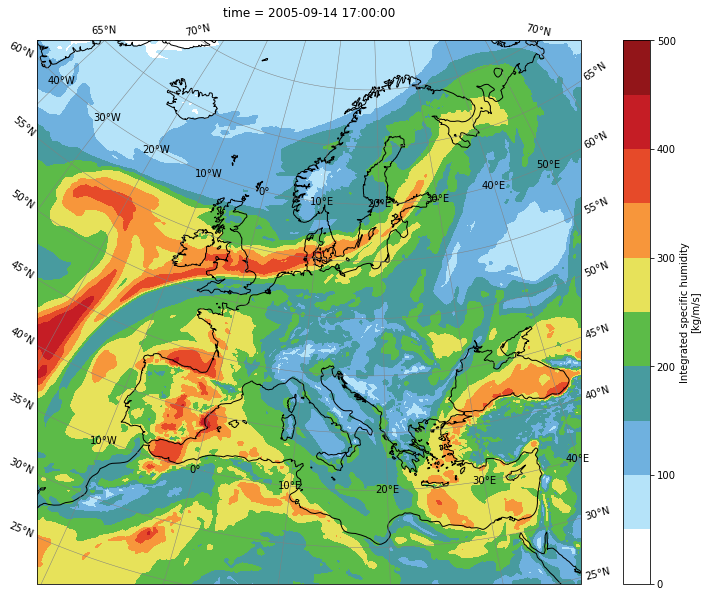

In [32]:
plot_contourf(
    qvi_.QVI.sel(time="2005-09-14T17:00:00").squeeze(),
    pole,
    vmin=0,
    vmax=500,
    levels=11,
)

### Show Atmospheric River Event, Sept. 2005, Norway

Rests of Hurricanes Maria and Nate, (Kristin), hit Norwegian coast on 14 sept. 2005.

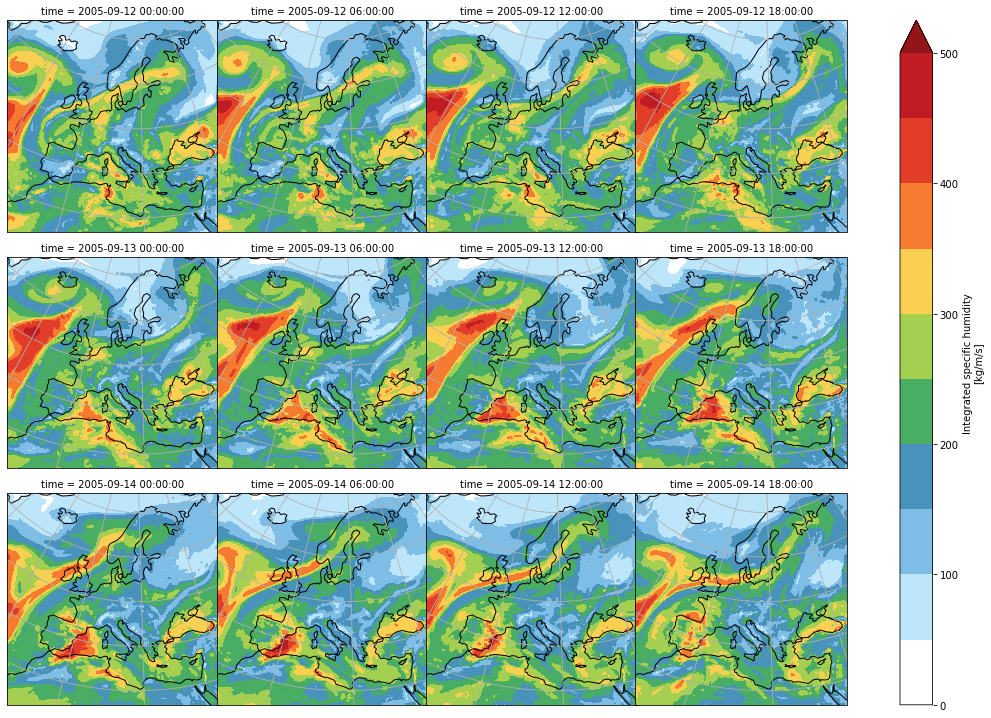

In [57]:
import cartopy.crs as ccrs
import cmaps

p = qvi_.QVI.sel(
    time=slice("2005-09-12T00:00:00", "2005-09-14T23:00:00", 6)
).plot.contourf(
    col="time",
    col_wrap=4,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    levels=11,
    vmin=0,
    vmax=500,
    figsize=(15, 10),
    subplot_kws={"projection": ccrs.RotatedPole(*pole)},
)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()